In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
import random
import scipy.signal
from math import log
import array
from scipy.signal import upfirdn,decimate
from scipy.special import erfc
from scipy import signal

In [2]:
def bin2int(x):
    y = 0
    for i,j in enumerate(x):
        y += j<<i
    return y


In [3]:
def method(byte,bps):
    arr = []
    for i in range(bps, 0, -1):
        arr.append((byte & 1<<i)>>i)
    return arr

In [4]:
def maxInd(p):
    b=max(p)
    k=0
    
    for h in range(0,len(p)):
        if (p[h]==b):
            k=h
    
    
    return k
        

In [5]:
def bi2de(test_list):
    res = 0
    for ele in test_list: 
        res = (res << 1) | ele    
    return res 

In [6]:
def addAWGN(x, SNR_dB):
    
    L=len(x)
    SNR = np.power(10,(SNR_dB/10)) #SNR to linear scale
    Esym=np.sum(abs(x)*abs(x))/L  #Calculate actual symbol energy
    
      
   
    N0=Esym/SNR #Find the noise spectral density
    
    noiseSigma =math.sqrt(N0)#Standard deviation for AWGN Noise when x is real
    n = noiseSigma*np.random.randn(1,L) #computed noise
       
    y = x + n  #received signal    
    return y

In [7]:

#Simulation of errors in MFSK 
def fsk_errors1(coherence,bps,Nsymb,nsamp,EbNo):
    #coherence=True   
    #bps=4
    #Nsymb=2000
    #nsamp=16
    #EbNo=5
        #Input Parameters
        # bps:      bits per symbol
        # Nsymb:    number of symbols to be simulated
        # nsamp:    number of samples per symbol (oversampling)
        # EbNo:     normalized signal-to-noise ratio (in dB)
    M=np.power(2,bps) #Number of different symbols (modulation order)
    BR=1              #Baud Rate
    fc=2*M*BR         #RF Frequency 
        #nbits=bps*Nsymb  number of simulated data bits

    T=1/BR     #one symbol perio
    Ts=1/nsamp # oversampling period
    Fs=1/Ts  #sampling frequency 
    k=np.arange(1,M+1)
    f=fc +BR*(k-(M+1)/2) # M frequencies in "non-coherent" distance (BR)
    SNR = EbNo + 10*np.log10(bps) - 10*np.log10(nsamp/2) # AWGN channel noise (in dB)
    
    x = np.transpose(np.random.randint(2, size=(bps,Nsymb)))     # Random binary data stream of (bps)x(Nsymb) bits
    y = [bin2int(z[::-1]) for z in x]  #Sequence of symbols to be sent
    tks = np.arange(0,1,Ts)
    tks=np.transpose(tks)




        # Sender: FSK signal
    s=np.zeros((1,len(tks)*Nsymb+1))
        #Create properly (f(i)) frequency modulated signal
    for k in range(0,len(x[:, 1])):
          # len(x[:, 1]) == Nsymb
            index=bi2de(x[k,:]) 
            #print(index)
            fk=f[index]
            tk = k*T + tks
            r= k*len(tk) + np.arange(1,len(tk)+1)
                                   #print(r)
            if coherence:
                th = 0
            else:
                th = 2*np.pi*np.random.uniform(0,1,1)


            s[0,r]=np.sin(2*np.pi*fk*tk + th)





    #print(s)
    #freq, Pxx_den =signal.welch(s,Fs)
    #Pxx_den=np.transpose(Pxx_den)
    #plt.figure(figsize=(13,15))
    #plt.semilogy(freq, Pxx_den)
    #plt.ylim([0.5e-3, 1])
    #plt.xlabel('frequency [Hz]')
    #plt.ylabel('PSD [V**2/Hz]')
    #plt.grid()
    #plt.show()
    #figure(1); welch(s, [], [], [], Fs/Td);


    # Channel: Noise addition to the bandpass signal
    snoisy = addAWGN(s,SNR)
    
    #freq, Pxx_den =signal.welch(snoisy,Fs)
    # Pxx_den=np.transpose(Pxx_den)
    #plt.figure(figsize=(13,15))
    #plt.semilogy(freq, Pxx_den)


    #plt.ylim([0.5e-3, 1])
    #plt.xlabel('frequency [Hz]')
    #plt.ylabel('PSD with Gaussian Noise [V**2/Hz]')
    #plt.grid()
    
    #plt.show()


      #figure(2); welch(snoisy, [], [], [], Fs/Td);




    # Receiver: FSK signal
    xr=np.zeros((int(len(tks)*Nsymb/nsamp),bps))

    for k in range(1,int(len(tks)*Nsymb/nsamp)): #len(snoisy)/nsamp == Nsymb
            tk = k*T + tks

            sk = np.take(snoisy, range((k-1)*nsamp, k*nsamp)) 
            smi = []
            #Coherent demodulation MLE
            if coherence:
                for i in range(0,M):
                    si=np.sin(2*np.pi*f[i]*tk)

                    smi[0:]=sum([np.multiply(sk,si)])


            # Non-coherent demodulation MLE
            else:
                for i in range(1,M):
                    si=np.sin(2*np.pi*f[i]*tk)
                    sq=np.cos(2*np.pi*f[i]*tk)
                    sm[0:]=np.power(np.power(sum([np.multiply(sk,si)]),2)+np.power(sum([np.multiply(sk,sq)]),2),0.5)

            p=np.transpose(smi)
            j=maxInd(p)
            r=int(np.binary_repr(j, width=bps))


            xr[k:] = method(r,bps) # convert in demodulation to binary 

    errors=0
    #print(xr.shape)
    for i in range(0,int(len(tks)*Nsymb/nsamp)):
        p=0
        for j in range(0,bps):
            if (x[i,j]==xr[i,j]):
                 p=p+1
        if(p!=bps):
            errors=errors+1
            
        
    

    return errors

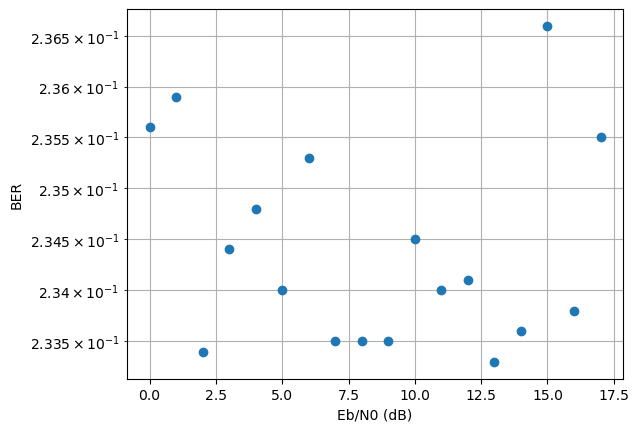

In [8]:
from scipy.special import erfc

coherence=True   
bps=4
L = 2**bps
Nsymb=2500
nsamp=16

ber = np.zeros(18)
for index in range (0,18):
    ber[index] = fsk_errors1(coherence,bps,Nsymb,nsamp,index)/(bps*Nsymb)
plt.semilogy(ber,'o')
plt.grid(True,which='both')
plt.xlabel("Eb/N0 (dB)")
plt.ylabel("BER")

EbN0_db = np.arange(0,18,1)
EbN0 = 10**(EbN0_db/10)
#ber_theoretical = (((L-1)/L)*erfc(np.sqrt(EbN0*(3*np.log2(L))/(L**2-1))))/k
#plt.semilogy(ber_theoretical)

#plt.legend(['Experimental','Theoretical'])

plt.show()

In [9]:
# N

In [10]:
ber

array([0.2356, 0.2359, 0.2334, 0.2344, 0.2348, 0.234 , 0.2353, 0.2335,
       0.2335, 0.2335, 0.2345, 0.234 , 0.2341, 0.2333, 0.2336, 0.2366,
       0.2338, 0.2355])